# Sprint 2 Stand Up

Short summary of this week's checkpoints.

In [1]:
import pandas as pd
import numpy as np
import os

# Set working directory
if not "/data/tables" in os.getcwd():
    os.chdir("../data/tables")

from pyspark.sql import SparkSession
from pyspark.shell import spark
from pyspark.sql import SQLContext
import pyspark.sql.functions as F
import matplotlib.pyplot as plt
from pyspark.sql.types import IntegerType

%matplotlib inline

    
spark = (
    SparkSession.builder.appName("MAST30034 Project 2")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config("spark.driver.memory", "4g")
    .config("spark.sql.broadcastTimeout", -1)
    .getOrCreate()
)

Welcome to
      ____              __
     / __/__  ___ _____/ /__
    _\ \/ _ \/ _ `/ __/  '_/
   /__ / .__/\_,_/_/ /_/\_\   version 3.1.2
      /_/

Using Python version 3.7.4 (default, Aug 13 2019 15:17:50)
Spark context Web UI available at http://169.254.224.157:4041
Spark context available as 'sc' (master = local[*], app id = local-1662483539820).
SparkSession available as 'spark'.


### Post Codes Discrepancies When Joining with ABS Datasets

In [28]:
postcodes = []

directory = os.getcwd() + '/POA/AUS/'
for root,dirs,files in os.walk(directory):
    for file in files:
        if file.endswith(".csv"):
            df = pd.read_csv(directory+file)
            poa = df['POA_CODE_2021'].apply(lambda x:int(x[3:])).to_list()
            postcodes += poa
            
postcodes = set(postcodes)


In [29]:
# Check available postcodes with the consumer data postcodes
consumer = spark.read.option("delimiter", "|").csv('tbl_consumer.csv', header = True)
consumer = consumer.withColumn("postcode", consumer["postcode"].cast(IntegerType()))

In [31]:
print("ABS Dataset:")
print(f"\tNumber of distinct postcodes: {len(postcodes)}\n\tPostcode range: {min(postcodes)} - {max(postcodes)}")
print("\nConsumer Dataset:")
print(f"\tNumber of distinct postcodes: {consumer.select('postcode').distinct().count()}",
      f"\n\tPostcode range: {consumer.agg({'postcode': 'min'}).collect()[0]['min(postcode)']} - {consumer.agg({'postcode': 'max'}).collect()[0]['max(postcode)']}")
unmatched_postcodes = consumer.where(~F.col('postcode').isin(postcodes)).count()
print(f"\nUnmatched Postcodes:\n\tNumber of unmatched postcodes: {unmatched_postcodes} out of {consumer.count()}")
print(f"\t% unmatched postcodes in consumer dataset: {(unmatched_postcodes/consumer.count())*100:.2f}%")


ABS Dataset:
	Number of distinct postcodes: 2643
	Postcode range: 800 - 9797

Consumer Dataset:
	Number of distinct postcodes: 3167 
	Postcode range: 200 - 9999

Unmatched Postcodes:
	Number of unmatched postcodes: 83181 out of 499999
	% unmatched postcodes in consumer dataset: 16.64%


### Solution - Reducing Granularity by Grouping based on SA2 Codes

In [ ]:
import pandas as pd
import io
import requests

def read_url_data(url, data_format='csv'):
    
    content = requests.get(url).content
    
    if data_format == 'xlsx':
        return pd.read_excel(content)
        
    else:
        return pd.read_csv(io.StringIO(content.decode('utf-8')))




In [ ]:
sa2_data = read_url_data("https://www.abs.gov.au/statistics/standards/australian-statistical-geography-standard-asgs-edition-3/jul2021-jun2026/access-and-downloads/allocation-files/SA2_2021_AUST.xlsx", 'xlsx')
postcode_database = read_url_data("https://www.matthewproctor.com/Content/postcodes/australian_postcodes.csv", "csv")


In [ ]:
sa2_data

In [ ]:
invalid_postcodes = consumer.where(~F.col('postcode').isin(postcodes))

In [ ]:
invalid_postcodes.count()

Postcodes in Consumer dataset fully matched the postcodes in the database. Thus, we will have full information on SA2 code grouping on the consumer dataset.

In [ ]:
postcode_sdf =spark.createDataFrame(postcode_database[['postcode', 'SA2_MAINCODE_2016']])
new_consumer = consumer.join(postcode_sdf,
                             consumer.postcode == postcode_sdf.postcode,
                             how='left')

### Highly Skewed Distribution of Dollar Value in Transaction Dataset

In [2]:
transaction = spark.read.parquet("transactions_20210828_20220227_snapshot/")

In [19]:
transaction.describe()

summary,user_id,merchant_abn,dollar_value,order_id,log(dollar_value)
count,4508106,4508106,4508106,4508106,4508106
mean,12042.986036264454,5.54256878138856E10,166.40234070352548,null,4.1058847083775625
stddev,6950.24163490185,2.532127355935058...,520.1543793822153,null,1.4389585490910382
min,1,10023283211,6.580118222113988E-6,000000d4-d252-4e2...,-11.931457845901827
max,24081,99990536339,77320.86980270348,fffffca5-42ab-49d...,11.255719182647296


In [20]:
subsample = (transaction.sample(0.2)
                        .select(['dollar_value','order_id'])
                        .toPandas()
            )

Text(0.5, 0, 'Dollar Value')

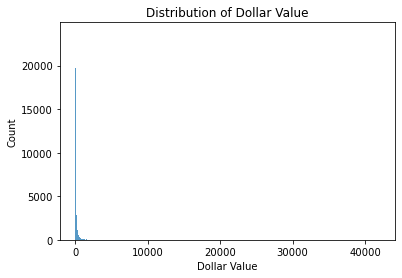

In [36]:
import seaborn as sns
sns.histplot(subsample['dollar_value'])
plt.title('Distribution of Dollar Value')
plt.xlabel('Dollar Value')

Text(0.5, 0, 'log(Dollar Value)')

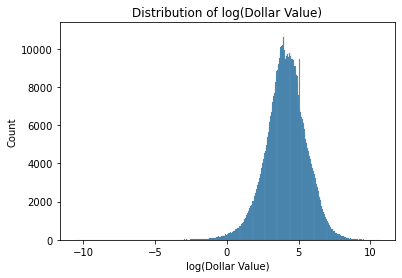

In [37]:
sns.histplot(np.log(subsample['dollar_value']))
plt.title('Distribution of log(Dollar Value)')
plt.xlabel('log(Dollar Value)')

### Solution - Outlier Detection and Removal

Extremely positive-skewed data. We attempt the rule-of-thumb outlier detection method $1.5\times IQR$ and check how much was removed.

In [6]:
lwr, upr = transaction.approxQuantile('dollar_value', [0.25, 0.75], 0)
iqr = upr - lwr
lwr_bound = lwr - 1.5 * iqr
upr_bound = upr + 1.5 * iqr

In [9]:
(lwr_bound, upr_bound)

(-160.33329721252636, 336.87985438863166)

Not a good outlier detection range (unrealistic lower bound, highly plausible upper bound), likely due to the highly skewed distribution of `dollar_value`.

In [11]:
transaction = transaction.withColumn('log(dollar_value)',
                                     F.log(F.col('dollar_value')))

In [12]:
lwr, upr = transaction.approxQuantile('log(dollar_value)', [0.25, 0.75], 0)
iqr = upr - lwr
lwr_bound = lwr - 1.5 * iqr
upr_bound = upr + 1.5 * iqr

In [15]:
lwr_bound, upr_bound = np.exp(lwr_bound), np.exp(upr_bound)

In [16]:
lwr_bound, upr_bound

(1.8902584230911532, 2078.7342190771465)

Much better outlier range, likely due to a more symmetric and normal distribution after taking the log of `dollar_value`. Comparable to the upper bound with the industry leading competitor (Afterpay) which has a maximum limit per transaction of $1500.

In [17]:
new_transaction = transaction.where(
    (F.col('dollar_value') >= lwr_bound) &
    (F.col('dollar_value') <= upr_bound)
)

In [23]:
subsample_2 = (new_transaction.sample(0.2)
                              .select(['dollar_value','order_id'])
                              .toPandas()
               )

Text(0.5, 0, 'Dollar Value')

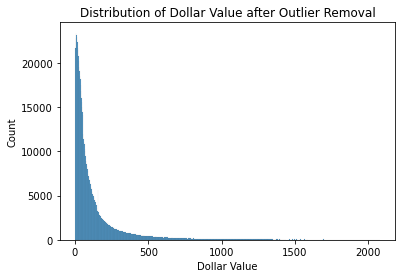

In [38]:
sns.histplot(subsample_2['dollar_value'])
plt.title('Distribution of Dollar Value after Outlier Removal')
plt.xlabel('Dollar Value')

Text(0.5, 0, 'log(Dollar Value)')

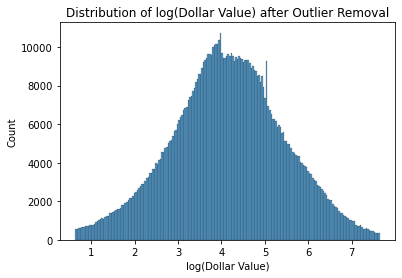

In [39]:
sns.histplot(np.log(subsample_2['dollar_value']))
plt.title('Distribution of log(Dollar Value) after Outlier Removal')
plt.xlabel('log(Dollar Value)')

In [27]:
pre_removal = transaction.count()
post_removal = new_transaction.count()
print(f"Number of instances after outlier removal: {post_removal}",
      f"\nNumber of outliers removed: {pre_removal - post_removal}",
      f"\n% data removed: {((pre_removal - post_removal)/pre_removal)*100:.2f}%")

Number of instances after outlier removal: 4407823 
Number of outliers removed: 100283 
% data removed: 2.22%


Much better outlier range. Distribution of `dollar_value` is still highly positive-skewed but that is just the nature of the data. The log(`dollar_value`) transformation improved the skewness overall.